<h1 style="color:rgb(0,120,170)">Solving memory task using the RNN</h1>


In this notebookwe will use the RNN from rnn_numpy notebook to solve the memory task. The task is to remember the first element in the input sequence. That is, given a sequence of random numbers, the RNN should output at the last time step the first element of the input sequence.This can be framed as a regression task. 

We will implement following steps:
1. Implement a generator that yields unlimimted training batches for the memory task.
2. Implement the mean squared error loss function and its derivative to be able to compute the gradients of the loss w.r.t. the network parameters.
3. Implement a learner class to facilitate the model training.
4. Train models for different sequence lengths and test up to which sequence length you are able to train the RNN succesfully. Visualize your results.
5. Visualize the vanishing gradient problem.

In [56]:
from collections import defaultdict
from typing import Tuple, Generator, Dict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tqdm

print('python version: 3.9.12')
print('numpy version:',np.__version__)
print('matplotlib version:',matplotlib.__version__)

python version: 3.9.12
numpy version: 1.21.5
matplotlib version: 3.5.1


<h2 style="color:rgb(0,120,170)">Task 1: Modified RNN implementation</h2>

In the last assignment your task was to implement a RNN forward and backward pass that works on a single input sequence. In reality, what you want to do most of the time is training using mini-batches of data samples. That is, you don't do the forward and backward pass for a single sample and then update your weights, but instead do the forward and backward pass for _n_ samples at the same time and calculate the average gradients of the _n_ samples for the weight update.  

In [2]:
class RNN(object):
    """Numpy implementation of sequence-to-one recurrent neural network for regression tasks."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):

        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # create and initialize weights of the network
        
        self.W = np.zeros((input_size, hidden_size))
        self.R = np.zeros((hidden_size, hidden_size))
        self.bs = np.zeros((hidden_size, 1))
        self.V = np.zeros((hidden_size, output_size))
        self.by = np.zeros((output_size, 1))
        self.reset_parameters()

        # place holder to store intermediates for backprop
        self.a = None
        self.y_hat = None
        self.grads = None
        self.x = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        seq_length, batch_size, _ = x.shape
              
        self.a = {0:np.zeros((batch_size,self.hidden_size))}
        for i in range(len(x)):
            s_t = x[i] @ self.W  + self.a[i] @ self.R + self.bs.T
            a_t = np.tanh(s_t)
            self.a[i + 1] = a_t
            
        y_hat = a_t @ self.V + self.by.T
        
        self.x = x.copy()
        self.y_hat = y_hat.copy()
        
        
        return y_hat

    def backward(self, d_loss: np.ndarray) -> Dict:
        seq_len, _ , _ = self.x.shape
        dV = np.zeros(self.V.shape)
        dby = np.zeros((self.by.shape))
        
        dW = np.zeros((seq_len ,*self.W.shape))
        dR = np.zeros((seq_len ,*self.R.shape))
        dbs = np.zeros((seq_len ,*self.bs.shape))
        
        for i in reversed(range(seq_len)):
            if i == seq_len - 1:
                dV =  self.a[i+1].T @ d_loss
                dby = d_loss.sum(axis=0).reshape(self.by.shape)
                delta_t = (d_loss @ self.V.T) * (1 - self.a[i+1] * self.a[i+1])
            else:
                delta_t = (delta_t @ self.R.T) * (1 - self.a[i+1] * self.a[i+1])
        

            dW[i] += self.x[i].T @ delta_t
            dR[i] += self.a[i].T @ delta_t
            dbs[i] = delta_t.sum(axis=0).reshape(dbs[i].shape)
            
        self.grads = {'dW': dW, 'dR': dR, 'dV': dV, 'dbs': dbs, 'dby': dby}
        return self.grads
        
        
    def update(self, lr: float):

        if not self.grads:
            raise RuntimeError("You have to call the .backward() function first")
            
            
            
        for key, grad in self.grads.items():
            if len(grad.shape) == 3:
                self.grads[key] = grad.sum(axis=0)
       
                                           
                                           
        self.V -= lr * self.grads['dV']
        self.W -= lr * self.grads['dW']
        self.R -= lr * self.grads['dR']
        self.bs -= lr * self.grads['dbs']
        self.by -= lr * self.grads['dby']
        # reset internal class attributes
        self.grads = {}
        self.y_hat, self.a = None, None
        
    def get_weights(self) -> Dict:
        return {'W': self.W, 'R': self.R, 'V': self.V, 'bs': self.bs, 'by': self.by}
    
    def set_weights(self, weights: Dict):
        if not all(name in weights.keys() for name in ['W', 'R', 'V']):
            raise ValueError("Missing one of 'W', 'R', 'V' keys in the weight dictionary")
        self.W = weights["W"]
        self.R = weights["R"]
        self.V = weights["V"]
        self.bs = weights["bs"]
        self.by = weights["by"]
        
    def reset_parameters(self):
        # recurrent weights initialized as identity matrix
        self.R = np.eye(self.hidden_size)
        
        # input to hidden and hidden to output initialized with LeCun initialization
        gain = np.sqrt(3 / self.input_size)
        self.W = np.random.uniform(-gain, gain, self.W.shape)
        gain = np.sqrt(3 / self.hidden_size)
        self.V = np.random.uniform(-gain, gain, self.V.shape)

<h2 style="color:rgb(0,120,170)">Task 2: Implement Datagenerator</h2>
Implementation of Python Generator function: given a `batch size` and a `sequence length`, returns two arrays, `x` and `y`. `x` is a batch of randomly generated input sequences of shape [sequence length, batch size, 1] and `y` the array of target values, which is the first sequence element for each sample in the batch.

In [3]:
def generate_samples(batch_size: int, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    """Data generator for memory task
    
    Note: Implement this function as a Python generator.
    
    Parameters
    ----------
    batch_size : int
        Number of samples in one batch
    seq_length : int
        Length of sequence of random numbers
        
    Returns
    -------
    x : np.ndarray
        Array of shape [sequence length, batch size, 1], where each sample is a sequence
        of random generated numbers between -1 and 1.
    y : np.ndarray
        Array of shape [batch size, 1], where each element i contains the label corresponding
        to sample i of the input array. The label is the first element of the sequence.
    
    """
    while True:
        x = np.random.uniform(-1,1,size = (seq_length,batch_size,1))
        y = x[0,:,:]
        yield (x,y)

<h2 style="color:rgb(0,120,170)">Task 3: Implement MSE Loss</h2>

Since the memory task is a regression type of task, we will use the mean squared error (MSE) as our loss function.

In [5]:
class MSELoss(object):
    def __init__(self):
        super(MSELoss, self).__init__()
        self.y_hat = None
        self.y_true = None
        
    def forward(self, y_hat: np.ndarray, y_true: np.ndarray) -> float:
        """ MSE loss
        
        Parameters
        ----------
        y_hat : np.ndarray
            Array containing the network predictions of shape [batch_size, 1]
        y_true : np.ndarray
            Array containing the true values of shape [batch_size, 1]
        
        Returns:
        The mean square error as a floating number.
        """

        self.y_hat = y_hat
        self.y_true = y_true
        return np.mean(np.square(self.y_true - self.y_hat))
    
    def backward(self) -> np.ndarray:
        """Backward pass of the MSE
        
        Returns
        -------
        The gradient w.r.t the network output of shape [batch_size, 1]
        """
          
        res = -2 * np.sum(self.y_true - self.y_hat,axis = 1)/self.y_true.shape[0]
        res = np.expand_dims(res, axis=1)
        return res

<h2 style="color:rgb(0,120,170)">Task 4: Implement Learner class</h2>

The task of this excercise is to implement a setup for training the RNN. That is, give the data generator from above, setup a model and connect the outputs to the MSELoss, channel the gradient of the MSELoss into the backward pass of the RNN and monitor the loss during training.

In [53]:
class Learner(object):
    def __init__(self, model: RNN, loss_obj: MSELoss, data_generator: Generator):
        """The initialization method
        
        Parameters
        ----------
        model : RNN
            An instance of the NumPy RNN implementation.
        loss_obj: MSELoss
            An instance of the mean squared error loss class.
        data_generator : Generator
            The data generator function implemented above
        """
        self.model = model
        self.loss_obj = loss_obj
        self.data_generator = data_generator
        
        self.loss_values = {}
        self.y_hats = None
        self.y_trues = None
        self.gradients = []
        
    def train(self, iter_steps: int, lr: float, log_steps: int = 50):
        """The training method.
        
        This function implements the training loop for a given number of
        iteration steps.
        
        Parameters
        ----------
        iter_steps : int
            Number of training iteration steps.
        lr : float
            Learning rate used for the weight update.
        log_steps : int
            Interval to log the training loss, by default 50.
        """
        if not self.loss_values:
            start_step = 0
        else:
            start_step = list(self.loss_values.keys())[-1]
        pbar = tqdm.tqdm_notebook(self.data_generator, total=iter_steps)
        for x, y in pbar:
            pbar.update()
            if pbar.n < iter_steps:
   
                #training steps
                y_hat = self.model.forward(x)
                self.y_trues = y
                self.y_hats = y_hat
                
                loss = self.loss_obj.forward(self.y_hats,self.y_trues)
                loss_grad = self.loss_obj.backward()
                gradients = self.model.backward(loss_grad)
                self.gradients.append(gradients)
                self.model.update(lr)
                
                # log loss value
                if pbar.n % log_steps == 0:
                    self.loss_values[start_step + pbar.n] = loss
                    pbar.set_postfix_str(f"Loss: {loss:5f}")
            else:
                tqdm.tqdm.write("finished training")
                break
    
    def make_predictions(self, n_batches: int) -> Tuple[np.ndarray, np.ndarray]:
        """Predictions for a given number of random batches.
        
        Parameters
        ----------
        n_batches : int
            Number of batches to get networks predictions for.
            
        Returns
        -------
        y_hats : np.ndarray
            NumPy array containing the concatenated network predictions for all batches.
        y_trues : np.ndarray
            NumPy array containing the concatenated true labels for all batches.
        """
        for i in range(n_batches):
            x,y = next(self.data_generator)
            y_hat = self.model.forward(x)
            if i == 0:
                y_hat_all = y_hat
                y_all = y
            else:
                y_hat_all = np.concatenate((y_hat_all, y_hat), axis=0)
                y_all = np.concatenate((y_all, y), axis=0)
        return (y_hat_all,y_all)
                    
    def plot_loss(self, figsize: Tuple[float, float]=(10, 8)):
        """Plot training loss curve.
        
        Parameters
        ----------
        figsize : Tuple[float, float]
            Matplotlib figure size, by default (10,8)
        """
        if not self.loss_values:
            raise RuntimeError("You have to train the network first.")
            
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(list(self.loss_values.keys()), list(self.loss_values.values()))
        ax.set_xlabel("Weight updates")
        ax.set_ylabel("MSE")
    
    def scatter_plot(self,figsize: Tuple[float, float]=(10, 8)):
        """Scatter plot of true vs predicted values.
        
        Parameters
        ----------
        figsize : Tuple[float, float]
            Matplotlib figure size, by default (10,8)
        """        
        if any(val is None for val in [self.y_hats, self.y_trues]):
            raise RuntimeError("Call the .make_predictions() method first")
    
        fig, ax = plt.subplots(figsize=figsize)
        ax.scatter(self.y_trues, self.y_hats)
        ax.plot([-1,1], [-1,1], '--', color='k', zorder=0)
        ax.set_xlabel("True values")
        ax.set_ylabel("Predicted values")

Now use everything implemented so far to train your first RNN.

/var/folders/yn/55hr75q51119y7clshplydwm0000gn/T/ipykernel_23953/2892444947.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm.tqdm_notebook(self.data_generator, total=iter_steps)


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


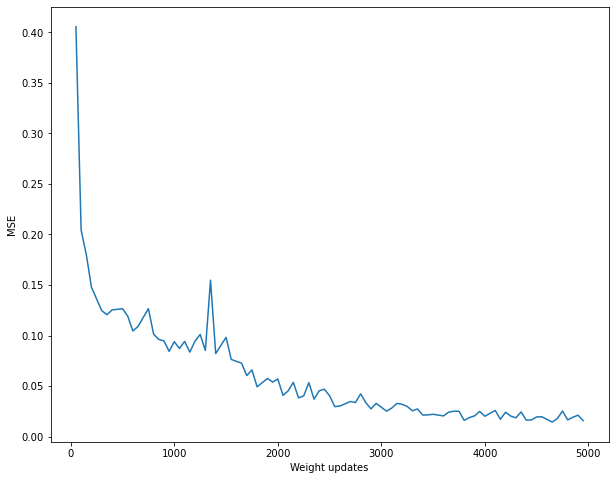

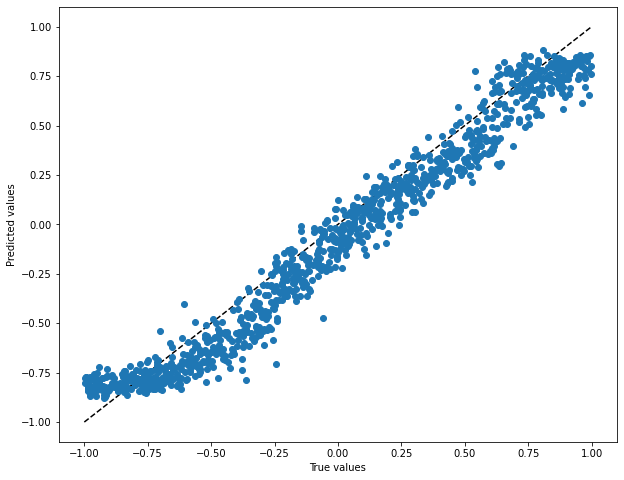

In [52]:
loss_obj = MSELoss()
model = RNN(input_size=1, hidden_size=10, output_size=1)
data_generator = generate_samples(batch_size=1024, seq_length=10)

learner = Learner(model=model, loss_obj=loss_obj, data_generator=data_generator)
learner.train(iter_steps=5000, lr=1e-2, log_steps=50)
learner.plot_loss()
_ = learner.make_predictions(n_batches=1)
learner.scatter_plot()

<h2 style="color:rgb(0,120,170)">Task 4: Train RNNs</h2>

Train RNNs to solve the memory task with different sequence length.

In [54]:
#Sequence length = 10: works perfectly
loss_10 = []
for i in range(10):
    model = RNN(input_size=1, hidden_size=10, output_size=1)
    data_generator_10 = generate_samples(batch_size=1024, seq_length= 10)
    learner = Learner(model=model, loss_obj=loss_obj, data_generator=data_generator_10)
    learner.train(iter_steps=5000, lr=1e-2, log_steps=500)
    loss_10.append(learner.loss_values)


    
#Sequence length = 20: problems with gradient descent, with te numer of iterations loss increases
loss_20 = []
for i in range(10):
    model = RNN(input_size=1, hidden_size=10, output_size=1)
    data_generator_20 = generate_samples(batch_size=1024, seq_length= 20)
    learner = Learner(model=model, loss_obj=loss_obj, data_generator=data_generator_20)
    learner.train(iter_steps=5000, lr=1e-2, log_steps=500)
    loss_20.append(learner.loss_values)   
    

    
    
#Sequence length = 30: problems with gradient descenz,with te numer of iterations loss increases
#At the end loss is huge in comparisson to sequence length = 10
loss_30 = []
for i in range(10):
    model = RNN(input_size=1, hidden_size=10, output_size=1)
    data_generator_30 = generate_samples(batch_size=1024, seq_length= 30)
    learner = Learner(model=model, loss_obj=loss_obj, data_generator=data_generator_30)
    learner.train(iter_steps=5000, lr=1e-2, log_steps=500)
    loss_30.append(learner.loss_values)




/var/folders/yn/55hr75q51119y7clshplydwm0000gn/T/ipykernel_23953/2892444947.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm.tqdm_notebook(self.data_generator, total=iter_steps)


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


Visualize the results, including error bars (from the repetitions).

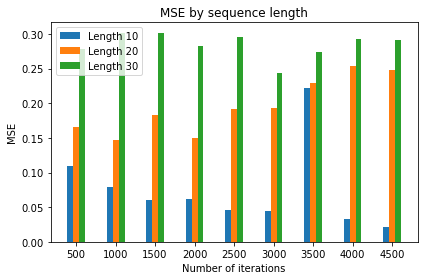

In [55]:
#calculating average losses(for every times) for every setting:
def loss_avg(loss):
    loss_avg = dict((key,0) for key in loss[0].keys())
    for i in range(len(loss)):
        for key,values in loss[i].items():
            loss_avg[key] += values
            if i == len(loss) - 1:
                  loss_avg[key] /= len(loss)
                    
    return loss_avg

loss_10 = loss_avg(loss_10)
#loss_15 = loss_avg(loss_15)
loss_20 = loss_avg(loss_20)
loss_30 = loss_avg(loss_30)


labels = list(loss_10.keys())
loss_10_means = list(loss_10.values())
#loss_15_means = list(loss_15.values())
loss_20_means = list(loss_20.values())
loss_30_means = list(loss_30.values())


x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width, loss_10_means, width, label='Length 10')
#bar2 = ax.bar(x , loss_15_means, width, label='Length 15')
bar2 = ax.bar(x, loss_20_means, width, label='Length 20')
bar3 = ax.bar(x + width, loss_30_means, width, label='Length 30')

#labels and title
ax.set_ylabel('MSE')
ax.set_xlabel('Number of iterations')
ax.set_title('MSE by sequence length')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

<h2 style="color:rgb(0,120,170)">Excercise 5: Vanishing Gradient</h2>

In the lecture you have heard that the problem of training RNNs on long sequences is called the vanishing gradient problem. Come up with your own ideas how you can visualize this problem. 

Hint: You could, for example, compare the gradients over time for two different sequence lengths - one sequence length, where the RNN still is able to learn and one, where it does not.

In [45]:
#getting gradients d_R(mean)
def get_grads(grads):
    d_R_grads = [] 
    for i in range(len(grads)):
        d_R_grads.append(np.abs(np.mean(grads[i]['dR'])))
                    
    return d_R_grads


#grads 10
model = RNN(input_size=1, hidden_size=10, output_size=1)
data_generator_10 = generate_samples(batch_size=1024, seq_length= 10)
learner = Learner(model=model, loss_obj=loss_obj, data_generator=data_generator_10)
learner.train(iter_steps=5000, lr=1e-2, log_steps=200)
grads_10 = get_grads(learner.gradients)

#grads 25
model = RNN(input_size=1, hidden_size=10, output_size=1)
data_generator_25 = generate_samples(batch_size=1024, seq_length= 25)
learner = Learner(model=model, loss_obj=loss_obj, data_generator=data_generator_25)
learner.train(iter_steps=5000, lr=1e-2, log_steps=200)
grads_25 = get_grads(learner.gradients)

/var/folders/yn/55hr75q51119y7clshplydwm0000gn/T/ipykernel_23953/2999345973.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm.tqdm_notebook(self.data_generator, total=iter_steps)


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


  0%|          | 0/5000 [00:00<?, ?it/s]

finished training


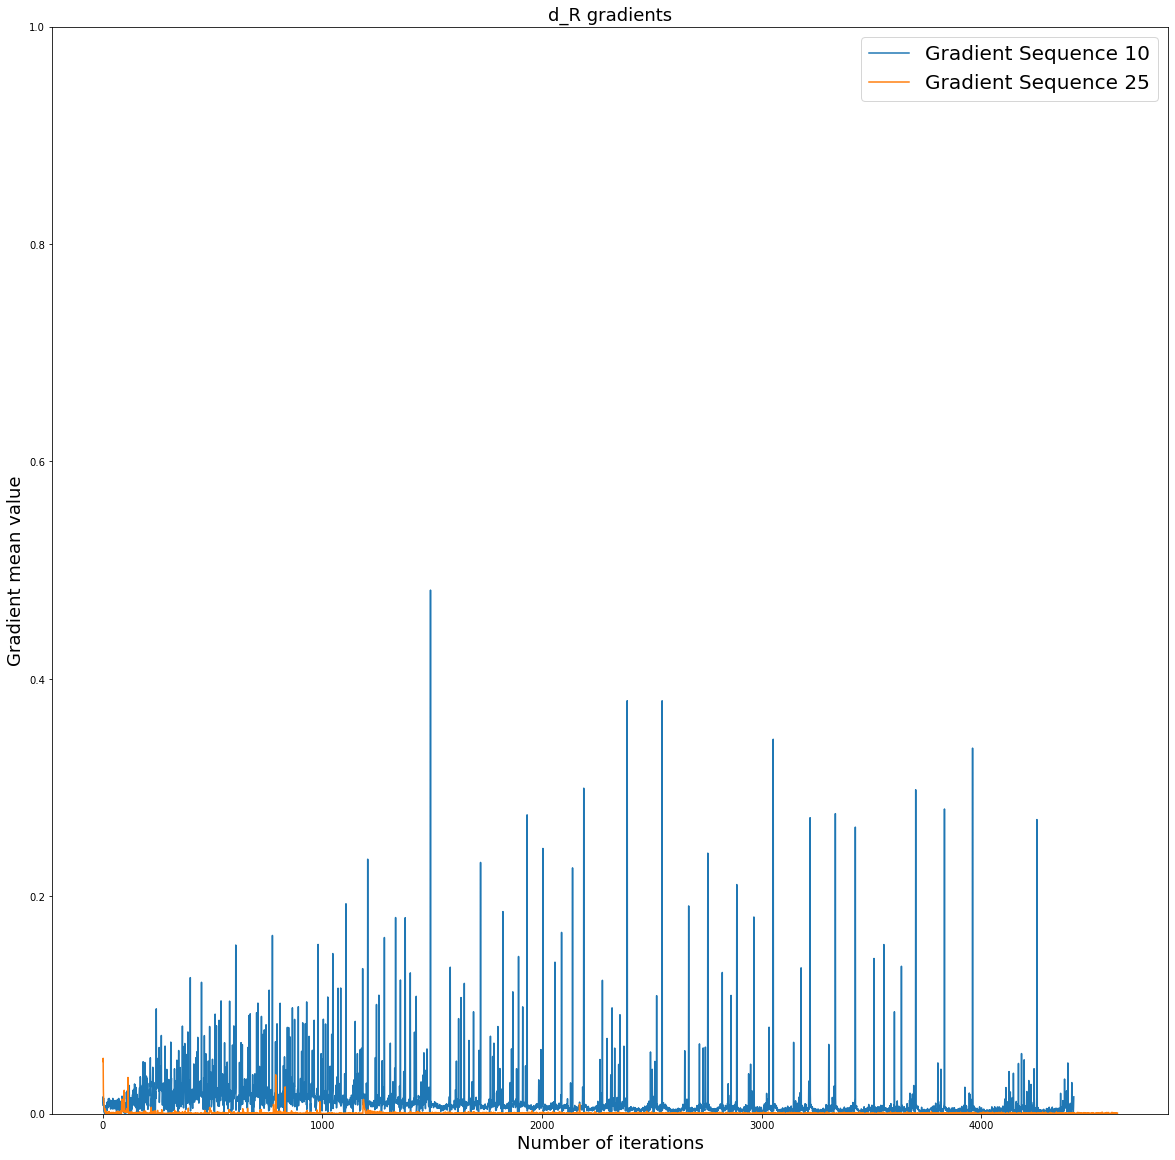

In [48]:
plt.figure(figsize=(20,20))
axes = plt.gca()
axes.set_ylim([0,1])
axes.set_ylabel('Gradient mean value',fontsize=18)
axes.set_xlabel('Number of iterations',fontsize=18)
axes.set_title('d_R gradients',fontsize=18)
plt.plot(grads_10, label = 'Gradient Sequence 10')
plt.plot(grads_25, label = 'Gradient Sequence 25')
plt.legend(prop={'size': 20})



